This notebook is primarily concerned with the multiple nonlinear optical interactions introduced in *Boyd's Nonlinear Optics*$^{[1]}$, from which all future equations will be referenced with the same keys as the original text. The dynamics of such interactions will be reviewed below, and code will output relevant graphs/media.
This notebook corresponds to part (b) in the REU schedule.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import RK45, odeint, solve_ivp
from scipy.special import expit
import math

## Sum-Frequency Generation (SFG)

Consider eqs. 2.2.10-2.2.12b from *Boyd*:
$$\frac{dA_1}{dz} = \frac{2id_{eff}\omega_1^2}{k_1c^2}A_3A_2^*e^{-i\Delta kz}$$
$$\frac{dA_2}{dz} = \frac{2id_{eff}\omega_2^2}{k_2c^2}A_3A_1^*e^{-i\Delta kz}$$
$$\frac{dA_3}{dz} = \frac{2id_{eff}\omega_3^2}{k_3c^2}A_1A_2e^{i\Delta kz}$$

$$\Delta k = k_1+k_2-k_3$$

In general, the undepleted-pump approximation (UPA) will be utilized to replicate results in chapter 2.6 of *Boyd*, where the amplitude $A_2$ can be assumed to be constant. Additionally, we assume that the field $\omega_3$ is not present at the input, giving boundary conditions: $A_3(0) = 0$, and $A_1(0) = C$; an arbitrary, complex number.
We let $K_1$ := $\frac{2id_{eff}\omega_1^2}{k_1c^2}A_2^*$, and $K_2$ := $\frac{2id_{eff}\omega_3^2}{k_3c^2}A_2$ for simplicity.
The following example graphs the solutions to the coupled wave-equations for the $\Delta k = 0$, and $\Delta k$ != 0 cases, congruent with figure 2.6.3.


We define the aforementioned variables below. Most values chosen are **arbitrary**.  

In [2]:
#Constants below. I made them simple, but will probably need to know reasonable values at one point. E.g, omega should be of order -16 for IR.

i = 0.0+1.0j; k1 = 1.3*10**12+0.003867934529567439+0j; k2 = 1.3*10**12; k3 = 2.6*10**12; 
w1 = 10**12; w2 = 3*10**12; w3 = w1 + w2; d = 10; c = 3*10**8; A2 = 2+0.0j

K1 = 2*i*w1**2*d/(k1*c**2)*np.conj(A2)
K3 = 2*i*w3**2*d/(k3*c**2)*A2

delta_k = k1+k2-k3 #4*kappa in this case.

We define two functions representing $A_1'$ and $A_3'$ to obtain $A_3$, and utilize the 4th order Runge-Kutta method to solve these equations numerically.

In [3]:
def dA3dz(z,S):
    A1, A3 = S
    return (K1*A3, K3*A1)

def dA3dz2(z, S): #delta_k != 0
    A1, A3 = S
    return (K1*A3*np.exp(-i*delta_k*z),K3*A1*np.exp(i*delta_k*z))

z_max = 10000

delta = 1

A1 = 10+0.0j
y0 = [A1,0]
y02 = [A1,0]
sol1 = RK45(dA3dz,0.0,y0,z_max, 10, 10)
sol2 = solve_ivp(dA3dz2,np.array([0,10000]),y02, t_eval = np.linspace(0,10000,1000))

z_sfg = [];
A3_sfg = []

z2_sfg = sol2.t
A3_sfg2 = np.abs(sol2.y[1])**2

for i in range(1000):
    sol1.step()
    A3_sfg.append(np.abs(sol1.y[1])**2)
    z_sfg.append(sol1.t) 
    if sol1.status == "finished":
        break

Below, $|A_3|^2$ is graphed with regards to z for both aforementioned phase differences.

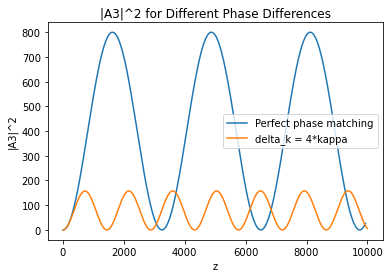

In [4]:
plt.plot(z_sfg,A3_sfg)
plt.plot(z2_sfg,A3_sfg2)
plt.xlabel("z")
plt.ylabel("|A3|^2")
plt.legend(["Perfect phase matching", "delta_k = 4*kappa"])
plt.title("|A3|^2 for Different Phase Differences")
plt.show()

Results are extremely similar to Fig 2.6.3! Magnitudes of x, y axes are irrelevant and simply a function of arbitrary variables, and the initial condition for $A_1$.


## Optical Parametric Amplification (OPA)

OPA utilizes much of the same dynamics as SFG, but there tends to be a difference in both methods' initial conditions.  
We simulate the following process without an (eqns. 2.9.1), and a different definition for the phase difference (eqn. 2.8.2):

$$\frac{dA_1}{dz} = \frac{2id_{eff}\omega_1^2}{k_1c^2}A_3A_2^*e^{-i\Delta kz}$$
$$\frac{dA_2}{dz} = \frac{2id_{eff}\omega_2^2}{k_2c^2}A_3A_1^*e^{-i\Delta kz}$$
$$\frac{dA_3}{dz} = \frac{2id_{eff}\omega_3^2}{k_3c^2}A_1A_2e^{i\Delta kz}$$

$$\Delta k = k_3 - (k_1+k_2)$$


We define variables again for convenience:

In [5]:
i = 0.0+1.0j; k1 = 1.3*10**12+0.003867934529567439*4+0j; k2 = 1.3*10**12; k3 = 2.60*10**12; w1 = 3*10**12; 
w3 = 5*10**12; w2 = w3 - w1
K1 = 2*1j*w1**2*d/(k1*c**2)
K2 = 2*1j*w2**2*d/(k2*c**2)
K3 = 2*1j*w3**2*d/(k3*c**2)
delta_k = -k1-k2+k3 # 4*kappa


And then solve with the same methodology as in SFG:

In [6]:
def dA2dz(z,S):
    #Constants above. I made them simple, but will probably need to know reasonable values at one point.
    A1, A2, A3 = S
    return (K1*A3*np.conj(A2), K2*A3*np.conj(A1), K3*A1*A2)

def dA2dz2(z, S): #delta_k != 0
    A1, A2, A3 = S
    return (K1*A3*np.conj(A2)*np.exp(1j*delta_k*z),K2*A3*np.conj(A1)*np.exp(1j*delta_k*z), 
            K3*A1*A2*np.exp(-1j*delta_k*z))

z_max = 400

delta = 1
A3 = 20+0.0j
A1 = 10+0.0j
y0 = [A1,0,A3]
y02 = [A1,0,A3]
sol1 = RK45(dA2dz,0.0,y0,z_max, z_max/1000, z_max/1000)
#sol2 = RK45(dA2dz2,0.0,y02,z_max) old code
sol2 = solve_ivp(dA2dz2,np.array([0,z_max]),y02, t_eval = np.linspace(0,z_max,1000))

z_OPA = [];
A1_OPA = []
A2_OPA = []
A3_OPA = []
z2_OPA = sol2.t
A1_OPA2 = np.abs(sol2.y[0]**2)
A2_OPA2 = np.abs(sol2.y[1]**2)
A3_OPA2 = np.abs(sol2.y[2]**2)
#z2 = [];
#A3_int2 = []

for i in range(1000):
    sol1.step()
    A1_OPA.append(np.abs(sol1.y[0])**2)
    A2_OPA.append(np.abs(sol1.y[1])**2)
    A3_OPA.append(np.abs(sol1.y[2])**2)
    z_OPA.append(sol1.t) 
    if sol1.status == "finished":
        break

First, a comparison of all three frequencies' intensities will be made:

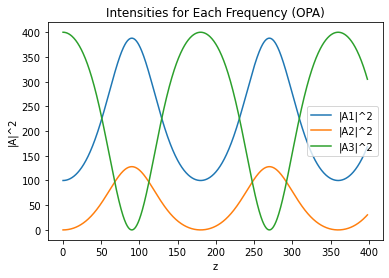

In [7]:
plt.plot(z_OPA,A1_OPA)
plt.plot(z_OPA,A2_OPA)
plt.plot(z_OPA,A3_OPA)
plt.xlabel("z")
plt.ylabel("|A|^2")
plt.legend(["|A1|^2", "|A2|^2","|A3|^2"])
plt.title("Intensities for Each Frequency (OPA)")
plt.show()

The plot demonstrates a resemblance to SFG, but with a horizontal movement. Furthermore, we can graph the difference in intensity due to phase matching:


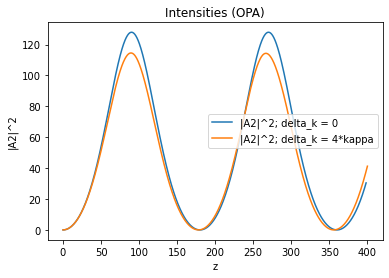

In [8]:
plt.plot(z_OPA,A2_OPA)
plt.plot(z2_OPA,A2_OPA2)
plt.xlabel("z")
plt.ylabel("|A2|^2")
plt.legend(["|A2|^2; delta_k = 0", "|A2|^2; delta_k = 4*kappa"])
plt.title("Intensities (OPA)")
plt.show()

The plot in this case indicates an increase in frequency, and a decrease in amplitude with increasing phase difference, much like in SFG.

## Second-Harmonic Generation (SHG)

SHG tends to differ greatly from the last two procedures. An inherent difference is that the fundamental frequency follows the relation $2\omega_{fundamental}$ = $\omega_{second}$. SHG has more exotic dynamics unseen in prior examples (eqns. 2.7.10-12):

$$\frac{dA_1}{dz} = \frac{2id_{eff}\omega_1^2}{k_1c^2}A_3A_2^*e^{-i\Delta kz}$$
$$\frac{dA_2}{dz} = \frac{id_{eff}\omega_2^2}{k_2c^2}A_1^2e^{i\Delta kz}$$

$$\Delta k =2k_1-k_2$$

Unique to SHG is the chance for the intensity to "flatline," after a point where both $\frac{dA_1}{dz}$, $\frac{dA_2}{dz}$ $\approx$ 0.
The intensities of waves with frequency $\omega_1$ and $\omega_2$, and with total phase matching will be compared in a plot, as well as the intensity of $\omega_2$ for various phase differences.

In [9]:
i = 0.0+1.0j; k1 = 1.3*10**12+0.003867934529567439*2+0j; k2 = 2.6*10**12; w1 = 10**12; w2 = 2*10**12; w3 = w1 + w2
delta_k1 = 0; d = 10; c = 3*10**8; A2 = 200+0.0j; 

K1 = 2*i*w1**2*d/(k1*c**2)
K2 = i*w2**2*d/(k2*c**2)

delta_k = 2*k1-k2 #4*kappa


def dAdz(z,S):
    #Constants above. I made them simple, but will probably need to know reasonable values at one point.
    A1, A2 = S
    return (K1*A2*np.conj(A1), K2*A1**2)

def dAdz2(z, S): #delta_k != 0
    A1, A2 = S
    return (K1*A2*np.conj(A1)*np.exp(-i*delta_k*z),K2*A1**2*np.exp(i*delta_k*z))

z_max = 300

delta = 1

A1 = 100+0.0j
y0 = [A1,0]
y02 = [A1,0]
sol1 = RK45(dAdz,0.0,y0,z_max, z_max/1000, z_max/1000)
#sol2 = RK45(dA3dz2,0.0,y02,z_max)
sol2 = solve_ivp(dAdz2,np.array([0,z_max]),y02, t_eval = np.linspace(0,z_max,1000))

z_shg = [];
A1_shg = []
A2_shg = []

z2_shg = sol2.t

A1_shg2 = np.abs(sol2.y[0])**2
A2_shg2 = np.abs(sol2.y[1])**2
#z2 = [];
#A3_int2 = []

for i in range(1000):
    sol1.step()
    A1_shg.append(np.abs(sol1.y[0])**2)
    A2_shg.append(np.abs(sol1.y[1])**2)
    z_shg.append(sol1.t) 
    if sol1.status == "finished":
        break


We can graph the intensities for both frequencies with perfect phase matching:

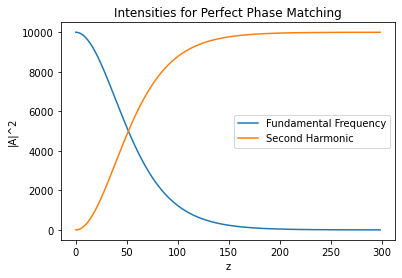

In [10]:
plt.plot(z_shg,A1_shg)
plt.plot(z_shg,A2_shg)
#plt.plot(z2,A1_int)
#plt.plot(z2,A2_int)
plt.xlabel("z")
plt.ylabel("|A|^2")
plt.legend(["Fundamental Frequency", "Second Harmonic"])
plt.title("Intensities for Perfect Phase Matching")
plt.show()

This demonstrates the aforementioned chance for both frequencies to maintain constant intensity. Furthermore, it is a good exercise to demonstrate the effect of phase matching on either of the two frequencies (reminiscent of fig. 2.7.4 in *Boyd*).

In [11]:
i = 0.0+1.0j; k1 = 1.3*10**12+0.003867934529567439*0.4+0j; k2 = 2.6*10**12; w1 = 10**12; 
w2 = 2*10**12; w3 = w1 + w2
delta_k1 = 0; d = 10; c = 3*10**8; A2 = 200+0.0j; 

K1 = 2*i*w1**2*d/(k1*c**2)
K2 = i*w2**2*d/(k2*c**2)

delta_k = 2*k1-k2 #4*kappa

def dAdz2(z, S): #delta_k != 0
    A1, A2 = S
    return (K1*A2*np.conj(A1)*np.exp(-i*delta_k*z),K2*A1**2*np.exp(i*delta_k*z))

z_max = 300

delta = 1

A1 = 100+0.0j

y02 = [A1,0]

#sol2 = RK45(dA3dz2,0.0,y02,z_max)
sol3 = solve_ivp(dAdz2,np.array([0,z_max]),y02, t_eval = np.linspace(0,z_max,1000))

z3_shg = sol3.t

A1_shg3 = np.abs(sol3.y[0])**2
A2_shg3 = np.abs(sol3.y[1])**2


In [12]:
i = 0.0+1.0j; k1 = 1.3*10**12+0.003867934529567439*5+0j; k2 = 2.6*10**12; w1 = 10**12; w2 = 2*10**12; w3 = w1 + w2
delta_k1 = 0; d = 10; c = 3*10**8; A2 = 200+0.0j; 

K1 = 2*i*w1**2*d/(k1*c**2)
K2 = i*w2**2*d/(k2*c**2)

delta_k = 2*k1-k2 #4*kappa

def dAdz2(z, S): #delta_k != 0
    A1, A2 = S
    return (K1*A2*np.conj(A1)*np.exp(-i*delta_k*z),K2*A1**2*np.exp(i*delta_k*z))

z_max = 300

delta = 1

A1 = 100+0.0j

y02 = [A1,0]

#sol2 = RK45(dA3dz2,0.0,y02,z_max)
sol4 = solve_ivp(dAdz2,np.array([0,z_max]),y02, t_eval = np.linspace(0,z_max,1000))

z4_shg = sol4.t

A1_shg4 = np.abs(sol4.y[0])**2
A2_shg4 = np.abs(sol4.y[1])**2


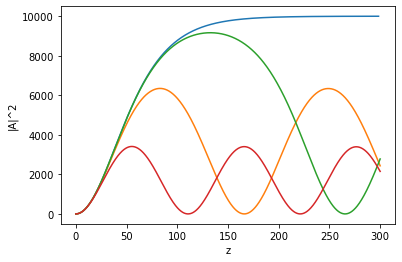

In [13]:
#plt.plot(z,A1_int)
plt.plot(z_shg,A2_shg)
#plt.plot(z2,A1_int)
plt.plot(z2_shg,A2_shg2)
plt.plot(z3_shg,A2_shg3)
plt.plot(z4_shg,A2_shg4)

plt.xlabel("z")
plt.ylabel("|A|^2")
plt.show()

It's important to note the elliptic nature of the above graph when a change of variables (with a real, normalized amplitude) is made, such as in figure 2.7.4.

## References:

[1]: Boyd, Robert W. Nonlinear Optics. San Diego, CA: Academic Press, 2003. Print.

(More to come I promise!)